In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras import layers
import numpy as np
import sklearn
from PIL import Image
import os
from matplotlib import pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import scale, OneHotEncoder
import math

# To filter warnings
import warnings 
warnings.filterwarnings('ignore')


## MLP Model

In [3]:
# extrach features from dataset

def extract_features(file_path, desired_length=300):
    x, sr = librosa.load(file_path, sr=None)

    result = []
    mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr).T, axis=0)
    result.append(mfcc)

    chroma = np.abs(librosa.stft(x))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=chroma, sr=sr).T, axis=0)
    result.append(chroma_stft)
    
    mel = np.mean(librosa.feature.melspectrogram(y=x, sr=sr).T, axis=0)
    result.append(mel)
        
    return np.hstack(result)
    

In [4]:
# Plotting the losses and accuracy
def plot_history(history):
    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='test_label')
    plt.xlabel('iterations')
    plt.ylabel('losses')
    plt.legend()
    
    plt.figure()
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='test_accuracy')
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.legend()

Loading dataset

In [16]:
# features = ['mel', 'mfcc', 'chroma'] (default)
from sklearn.model_selection import train_test_split

def load_dataset(type='emotion', features=['mel', 'mfcc', 'chroma'], train_size=0.8):
    dir = r'C:\Users\rupes\OneDrive\Documents\Data Science\Speech Emotion Recognition\audio_dataset'
    
    X = []
    Y = []

    for folder in os.listdir(dir):
        folder_path = os.path.join(dir, folder)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)

                if os.path.isfile(file_path):
                        features_extracted = extract_features(file_path)

                        if features_extracted is not None:
                            X.append(features_extracted)
                            
                            audio_path = file_path.split('\\')[-1] 
                            parts = audio_path.split('.')[0].split('-')

                            if type == 'emotion':
                                Y.append(int(parts[2]))
                            elif type == 'gender':
                                actor_id = int(parts[6]) 
                                gender = 0 if actor_id % 2 == 0 else 1
                                Y.append(gender)

    # Check if Y is empty before one-hot encoding
    if len(Y) == 0:
        print("No valid audio files processed for type:", type)
        return None, None, None, None

    X = np.array(X)
    X = scale(X)  # Normalize the features
    Y = np.array(Y).reshape(-1, 1)

    # One-hot encode the labels
    encoder = OneHotEncoder()
    Y = encoder.fit_transform(Y).toarray()
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    return x_train, y_train, x_test, y_test



In [17]:
# Loading the data
xg_train, yg_train, xg_test, yg_test = load_dataset(type='gender')
xe_train, ye_train, xe_test, ye_test = load_dataset(type='emotion')

In [18]:
print('xe_train shape:', xe_train.shape)  # Should be (num_samples, timesteps, features)
print('ye_train shape:', ye_train.shape)  # Should be (num_samples,) for classification
print('Unique labels:', np.unique(ye_train))

xe_train shape: (1152, 160)
ye_train shape: (1152, 8)
Unique labels: [0. 1.]


In [7]:
# Building model with TensorFlow
# n_layer1 = 100, n_layer2 = 75, n_layer3 = 40, n_layer4 = 20

def model(x_train, y_train, x_test, y_test):
    model = tf.keras.Sequential()
    model.add(layers.Dense(120, input_shape = (x_train.shape[1],), activation='relu',))
    model.add(layers.Dense(80, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    # Use Adam optimizer with learning rate decay
    initial_learning_rate = 0.0002
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

    # Early Stopping to avoid overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(x_train, y_train, batch_size=256, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[early_stopping])

    # plot the history
    plot_history(history)

    # model summary and result on test_data
    print(model.summary())
    result = model.evaluate(x_test, y_test)
    print(result)
    
    return model

# Emotion Model

Epoch 1/500
5/5 [==============================] - 1s 61ms/step - loss: 2.1580 - accuracy: 0.0781 - val_loss: 2.1112 - val_accuracy: 0.0833
Epoch 2/500
5/5 [==============================] - 0s 12ms/step - loss: 2.0996 - accuracy: 0.1024 - val_loss: 2.0813 - val_accuracy: 0.1319
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 2.0656 - accuracy: 0.1406 - val_loss: 2.0604 - val_accuracy: 0.1250
Epoch 4/500
5/5 [==============================] - 0s 12ms/step - loss: 2.0413 - accuracy: 0.1762 - val_loss: 2.0425 - val_accuracy: 0.1597
Epoch 5/500
5/5 [==============================] - 0s 16ms/step - loss: 2.0206 - accuracy: 0.1970 - val_loss: 2.0262 - val_accuracy: 0.1944
Epoch 6/500
5/5 [==============================] - 0s 14ms/step - loss: 2.0009 - accuracy: 0.2196 - val_loss: 2.0110 - val_accuracy: 0.2049
Epoch 7/500
5/5 [==============================] - 0s 12ms/step - loss: 1.9835 - accuracy: 0.2387 - val_loss: 1.9958 - val_accuracy: 0.2118
Epoch 8/500
5/5 [===

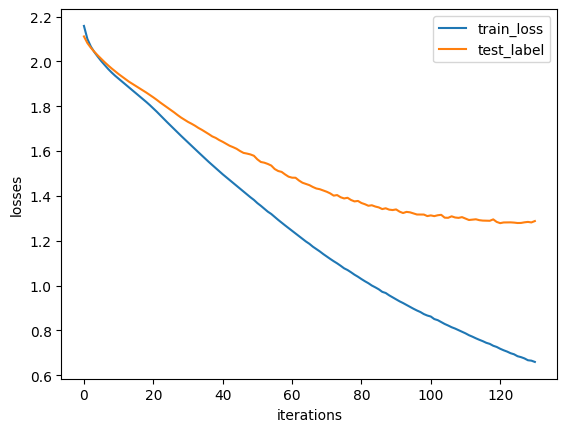

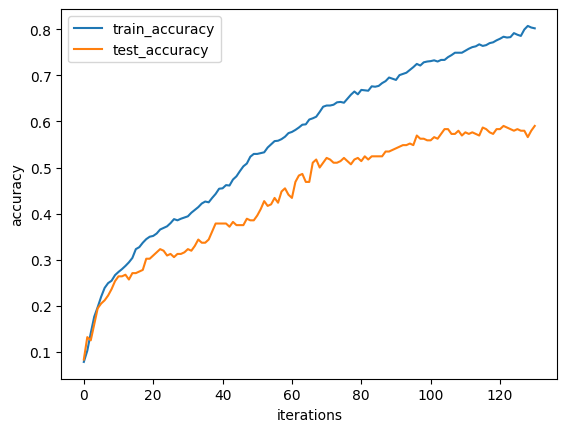

In [8]:
emotion_model = model(xe_train, ye_train, xe_test, ye_test)

In [9]:
print(emotion_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               19320     
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 50)                4050      
                                                                 
 dense_3 (Dense)             (None, 20)                1020      
                                                                 
 dense_4 (Dense)             (None, 8)                 168       
                                                                 
Total params: 34,238
Trainable params: 34,238
Non-trainable params: 0
_________________________________________________________________
None


# Gender Model

Epoch 1/500
5/5 [==============================] - 1s 53ms/step - loss: 0.7232 - accuracy: 0.4062 - val_loss: 0.6929 - val_accuracy: 0.5556
Epoch 2/500
5/5 [==============================] - 0s 12ms/step - loss: 0.6648 - accuracy: 0.6806 - val_loss: 0.6471 - val_accuracy: 0.7639
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 0.6211 - accuracy: 0.8160 - val_loss: 0.6060 - val_accuracy: 0.8333
Epoch 4/500
5/5 [==============================] - 0s 12ms/step - loss: 0.5839 - accuracy: 0.8542 - val_loss: 0.5691 - val_accuracy: 0.8715
Epoch 5/500
5/5 [==============================] - 0s 12ms/step - loss: 0.5482 - accuracy: 0.8698 - val_loss: 0.5334 - val_accuracy: 0.8889
Epoch 6/500
5/5 [==============================] - 0s 11ms/step - loss: 0.5118 - accuracy: 0.8872 - val_loss: 0.4968 - val_accuracy: 0.8993
Epoch 7/500
5/5 [==============================] - 0s 11ms/step - loss: 0.4737 - accuracy: 0.8976 - val_loss: 0.4591 - val_accuracy: 0.9028
Epoch 8/500
5/5 [===

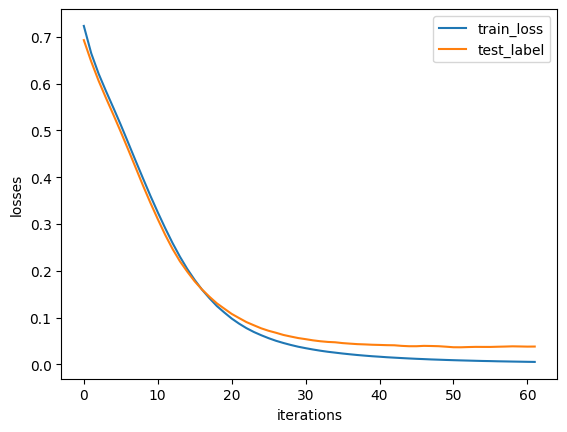

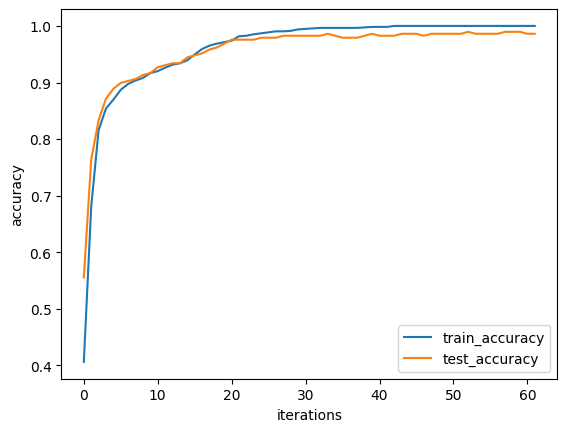

In [10]:
gender_model = model(xg_train, yg_train, xg_test, yg_test)

In [11]:
print(gender_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 120)               19320     
                                                                 
 dense_6 (Dense)             (None, 80)                9680      
                                                                 
 dense_7 (Dense)             (None, 50)                4050      
                                                                 
 dense_8 (Dense)             (None, 20)                1020      
                                                                 
 dense_9 (Dense)             (None, 2)                 42        
                                                                 
Total params: 34,112
Trainable params: 34,112
Non-trainable params: 0
_________________________________________________________________
None


# Emotion & Gender Prediction

In [ ]:
# Function to predict emotion and gender from an audio file
def predict_emotion_gender(audio_file):
    try:
        # Load the audio file
        audio, sr = librosa.load(audio_file, sr=22050)

        # Extract features
        features = ['mfcc', 'chroma', 'mel']
        feature_vector = extract_features(audio, features, sr)

        feature_vector = scale(feature_vector)

        # Predict emotion
        emotion_pred = emotion_model.predict(feature_vector)
        predicted_emotion = np.argmax(emotion_pred, axis=1)[0]

        # Predict Gender 
        gender_pred = gender_model.predict(feature_vector)
        predicted_gender = np.argmax(gender_pred, axis=1)[0]

        # Map the predicted values back to their respective categories
        emotion_labels = {0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
        gender_labels = {0: 'female', 1: 'male'}

        # Output the results
        print(f"Predicted Emotion: {emotion_labels[predicted_emotion]}")
        print(f"Predicted Gender: {gender_labels[predicted_gender]}")

    except Exception as e:
        print(f"Error processing the audio file: {e}")

# Test the model with an audio file
audio_path = r'audio_dataset\Actor_01\03-01-05-01-01-02-01.wav'
predict_emotion_gender(audio_path)
